### (Bundesliga) game prediction

Simple model for the predictions of soccer games: How many goals a team scores.

As data only the results from prior games are used. 

#### Loading and processing of data 

In [3]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [5]:
# some simple preprocessing of the data
clubs = pd.read_csv("bundesliga_Verein.csv", sep=';')
del(clubs["Unnamed: 3"])
# for convinience the club id should start with 0
clubs.V_ID = clubs.V_ID - 1
clubs = clubs.set_index("V_ID")
#clubs

In [6]:
top_club_ids = clubs[clubs.Liga==1].index
top_club_ids

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], dtype='int64', name=u'V_ID')

In [7]:
games = pd.read_csv("bundesliga_Spiel.csv", sep=';')
del(games["Unnamed: 8"])
# for convinience the club id should start with 0
games.Heim = games.Heim-1
games.Gast = games.Gast-1

In [8]:
top_games = games[games.Heim.isin(top_club_ids)]

In [9]:
#top_games

In [10]:
# todo: automatically 
actual_date = "2015-12-30"
top_games = top_games[games.Datum < actual_date]
len(top_games)

/home/benni/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


153

In [11]:
import pymc
import numpy as np

In [12]:
#c = [[i,j] for i in top_club_ids if i!=j for j in top_club_ids]

In [13]:
def get_toto_results():
    results_ = list()
    toto_result = list()
    for i in top_games.iterrows():
        r = i[1]
        gg = r.Tore_Heim
        ag = r.Tore_Gast
        re = (1 if gg>ag else 2 if gg<ag else 0)
        rr = (1 if gg>ag else -1 if gg<ag else 0)
        toto_result.append((r.Heim, r.Gast, re))
        results_.append((r.Heim, r.Gast, rr))
    return toto_result, results_
toto_results_, results_ = get_toto_results()

In [14]:
def get_goal_results(gh="Tore_Gast"):
    result = list()
    for i in top_games.iterrows():
        r = i[1]
        result.append((r.Heim, r.Gast, r[gh]))
    return result

away_goals_ = get_goal_results("Tore_Gast")
home_goals_ = get_goal_results("Tore_Heim")

In [15]:
#away_goals_

In [16]:

low = 0.0000000001

Idea: The number of goals a team scores can be modeled with a Poisson distribution.

#### Poisson distribution

Probability for outcome $k \in \{0, 1, 2, \dots\}$
 
$$
P_\lambda (k) = \frac{\lambda^k}{k!}\, \mathrm{e}^{-\lambda}
$$

with parameter $\lambda>0$
- $\lambda$ is also the expectation and variance of the distribution

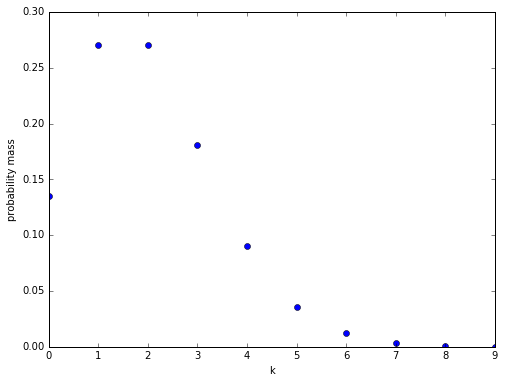

In [17]:
import scipy.stats
k=np.arange(0,10)
lambda_= 2

plt.figure(figsize=(8,6))
plt.plot(k, scipy.stats.poisson.pmf(k, lambda_), 'bo', ms=6, label='poisson pmf')
plt.xlabel("k")
plt.ylabel("probability mass")

#### Probabilistic Model

Each team $i$ has a offence and defence strength (distribution). (Note that the average goals per game $\approx 3 \Rightarrow \Delta \mu=1.5$):

$$
 offence_i \sim \mathcal N(\mu=1.5, \tau=1) 
$$
$$
 defence_i \sim \mathcal N(\mu=0, \tau=1) 
$$

$\mathcal N$ is the Gaussian distribution with parameters 
- mean: $\mu$
- precision: $\tau=1/\sigma^2$ (variance: $\sigma^2$)

Model: The number of goals that team $i$ scores against team $j$ is Poisson distributed with 

$$
 goals_{ij} = Poisson \left(\lambda = (offence_i-defence_j) \right)
$$


In [18]:
import daft
def plot_model():
    pgm = daft.PGM([6.3, 4.05], origin=[-1., -1.], aspect=1.)
    pgm.add_node(daft.Node("mu_o", r"$\mu_o$", .5, .5, fixed=True))
    pgm.add_node(daft.Node("tau_o", r"$\tau_o$", .5, 1.5, fixed=True))    
    pgm.add_node(daft.Node("o_i", r"o$_i$", 1.5, 1))
    
    pgm.add_node(daft.Node("tau_d", r"$\tau_d$", 2., 3., fixed=True))
    pgm.add_node(daft.Node("mu_d", r"$\mu_d$", 3., 3., fixed=True))
    pgm.add_node(daft.Node("d_j", r"d$_j$", 2.5, 2.2))
    
    #pgm.add_node(daft.Node("Delta", r"$\Delta_{ij}$", 2.5, 1))
    pgm.add_node(daft.Node("g", r"g$_{ij}$", 2.5, 1., observed=True))

    
    # Add in the edges.
    pgm.add_edge("mu_o", "o_i")
    pgm.add_edge("tau_o", "o_i")
    pgm.add_edge("mu_d", "d_j")
    pgm.add_edge("tau_d", "d_j")
    pgm.add_edge("o_i", "g")
    pgm.add_edge("d_j", "g")
    #pgm.add_edge("Delta", "g")
    # And plates.
    pgm.add_plate(daft.Plate([2., 0.2, 1., 2.5], label=r"$j$", shift=0.))
    pgm.add_plate(daft.Plate([1., 0.5, 2.2, 1.1], label=r"$i$", shift=0.))
    pgm.render()

ImportError: No module named daft

### Graphical representation of the model

In [19]:
plot_model()

NameError: name 'plot_model' is not defined

In [20]:
#top_club_ids
#home_goals_ # (home_team_id, away_team_id, goals_of_home_team)
#away_goals_ # (home_team_id, away_team_id, goals_of_away_team)

### Implementation with pymc

In [21]:
offence = [pymc.Normal("offence%i"%i, tau=1., mu=1.5) for i in top_club_ids]
defence = [pymc.Normal("defence%i"%i, tau=1., mu=0.) for i in top_club_ids]

 
home_goals = [pymc.Poisson("home_goals_%i_%i" % (heim,gast), 
                 observed=True, value=goals,
                 mu = pymc.Lambda("home_rate_%i_%i" % (heim, gast),
                 lambda o=offence[heim], d=defence[gast]: low if o-d<0. else o-d))  
              for i,(heim, gast, goals) in enumerate(home_goals_)]

away_goals = [pymc.Poisson("away_goals_%i_%i" % (heim,gast), 
                 observed=True, value=goals,
                 mu = pymc.Lambda("away_rate_%i_%i" % (heim, gast),
                 lambda o=offence[gast], d=defence[heim]: low if o-d<0. else o-d))  
              for i,(heim, gast, goals) in enumerate(away_goals_)]


In [22]:
#home_goals_

#### Sampling with pymc

In [23]:
mcmc = pymc.MCMC([offence, defence, home_goals, away_goals])
nb_samples=12000
burn=4000
mcmc.sample(nb_samples, burn=burn)#, thin=50)

 [-----------------100%-----------------] 12001 of 12000 complete in 89.1 sec

In [24]:
#plt.hist(mcmc.trace("noise_prior")[:])

In [33]:
id_2_club = dict()
for i in top_club_ids: 
    id_2_club[i] = clubs["Name"][i]

In [34]:
id_2_club[6]

'Borussia Dortmund'

In [35]:
#np.random.normal?

In [36]:
import scipy.stats
def print_sample_results(most_probable=True):
    for i in top_club_ids: 
        for j in top_club_ids:
            if i!=j:
                if most_probable:
                    k=0
                    h=nb_samples-burn
                else:
                    k = np.random.randint(low=0, high=nb_samples - burn)
                    h=k+1
                
                goals_home = np.random.poisson(diff)
                goals_away = np.random.poisson(d)
        
                print clubs[clubs.index==i]["Name"][i].decode('latin'), "-",
                print clubs[clubs.index==j]["Name"][j].decode('latin'), " : ",
                print scipy.stats.mode(goals_home).mode[0], "-",
                print scipy.stats.mode(goals_away).mode[0]

In [105]:
def get_diff1(h,k,i,j):
    diff = mcmc.trace("offence%i"%i)[k:h] - mcmc.trace("defence%i"%j)[k:h]
    d = mcmc.trace("offence%i"%j)[k:h] - mcmc.trace("defence%i"%i)[k:h]
    return diff, d                   
             
#TODO clean code    
def print_sample_results(most_probable=True, diff_func=get_diff1, print_hook=None):
    p=0
    pp=0
    nb_p=0
    for i in top_club_ids: 
        for j in top_club_ids:
            if i!=j:
                if most_probable:
                    k=0
                    h=nb_samples - burn
                else:
                    k = np.random.randint(low=0, high=nb_samples - burn)
                    h = k+1
                    
                diff, d = get_diff1(h,k,i,j)
                diff[diff<0.]=low
                d[d<0.]=low
                
                goals_home = np.random.poisson(diff)
                goals_away = np.random.poisson(d)
        
                print clubs[clubs.index==i]["Name"][i].decode('latin'), "-",
                print clubs[clubs.index==j]["Name"][j].decode('latin'), "/ prediction: ",
                
                h_goals = scipy.stats.mode(goals_home).mode[0]
                print h_goals, #" (%2.1f)"%(diff.mean()), 
                print "-",
                a_goals = scipy.stats.mode(goals_away).mode[0]
                print a_goals, #" (%2.1f)"%(d.mean()), d.mean()
                
                # probability for each goal count
                print "\n goal probability for " + clubs[clubs.index==i]["Name"][i].decode('latin')
                probshome = scipy.stats.itemfreq(goals_home)
                # print out the probability
                for p in range(probshome.shape[0]):
                    percent = float(probshome[p][1] / 8000.0 * 100.0)
                    print "Goals: " + str(probshome[p][0]) + " - " + str(percent) + "%" 
                    
                # probability for each goal count
                print "\n goal probability for " + clubs[clubs.index==j]["Name"][j].decode('latin')
                probsaway = scipy.stats.itemfreq(goals_away)
                # print out the probability
                for p in range(probsaway.shape[0]):
                    percent = float(probsaway[p][1] / 8000.0 * 100.0)
                    print "Goals: " + str(probsaway[p][0]) + " - " + str(percent) + "%"
                
                game=top_games[((top_games['Heim']==i) & (top_games['Gast']==j))]
                predicted = (1 if h_goals>a_goals else 2 if h_goals<a_goals else 0)
                if not game.empty:
                    hg = game.Tore_Heim.values[0]
                    ag = game.Tore_Gast.values[0]
                    print "\n result : ",hg, ":", ag,
                    result = (1 if hg>ag else 2 if hg<ag else 0)
                    nb_p +=1
                    if result == predicted:
                        p+=1  
                if print_hook:
                    pr = print_hook(k,h,i,j)
                    if result is not None and result == pr:
                        pp+=1
                print
                result=None
    return nb_p, p, pp

def get_goal_distribution():
    diff, d = get_diff1(h,k,i,j)
    diff[diff<0.]=low
    d[d<0.]=low
                

In [106]:
# sampling most probable results according to the model
#print_sample_results(most_probable=False)

# Sample results from a sample of the trace
nb_p, p, _ = print_sample_results(most_probable=True)

FC Bayern München - VfL Wolfsburg / prediction:  2 - 0 
 goal probability for FC Bayern München
Goals: 0 - 9.8875%
Goals: 1 - 22.5625%
Goals: 2 - 25.0875%
Goals: 3 - 20.025%
Goals: 4 - 12.6625%
Goals: 5 - 5.9125%
Goals: 6 - 2.4625%
Goals: 7 - 0.9375%
Goals: 8 - 0.375%
Goals: 9 - 0.0375%
Goals: 10 - 0.025%
Goals: 11 - 0.025%

 goal probability for VfL Wolfsburg
Goals: 0 - 49.525%
Goals: 1 - 32.4625%
Goals: 2 - 12.975%
Goals: 3 - 3.6875%
Goals: 4 - 1.05%
Goals: 5 - 0.25%
Goals: 6 - 0.0375%
Goals: 7 - 0.0125%

 result :  5 : 1
FC Bayern München - Borussia Mönchengladbach / prediction:  2 - 1 
 goal probability for FC Bayern München
Goals: 0 - 5.575%
Goals: 1 - 15.375%
Goals: 2 - 22.0625%
Goals: 3 - 21.35%
Goals: 4 - 16.75%
Goals: 5 - 10.0375%
Goals: 6 - 4.675%
Goals: 7 - 2.55%
Goals: 8 - 1.0625%
Goals: 9 - 0.275%
Goals: 10 - 0.225%
Goals: 11 - 0.05%
Goals: 12 - 0.0125%

 goal probability for Borussia Mönchengladbach
Goals: 0 - 30.9%
Goals: 1 - 35.05%
Goals: 2 - 21.125%
Goals: 3 - 8.9625%


In [65]:
print "train data accuracy", float(p)/nb_p

train data accuracy

TypeError: only length-1 arrays can be converted to Python scalars

In [32]:
# mean of offence strength
for i in top_club_ids: 
    print clubs[clubs.index==i]["Name"][i].decode('latin'), " ", mcmc.trace("offence%i"%i)[:].mean()

FC Bayern München   2.60372376841
VfL Wolfsburg   1.62681468867
Borussia Mönchengladbach   2.09806616725
Bayer Leverkusen   1.39483529595
FC Augsburg   1.35143325535
FC Schalke 04   1.48991003059
Borussia Dortmund   2.62953854559
1899 Hoffenheim   1.26459753153
Eintracht Frankfurt   1.27968334435
SV Werder Bremen   1.08631022333
1. FSV Mainz 05   1.35802225188
1. FC Köln   1.13746873822
Hannover 96   1.25489477686
VfB Stuttgart   1.42341479553
Hertha BSC   1.53955775245
Hamburger SV   1.09381205758
FC Ingolstadt 04   0.732793454153
SV Darmstadt 98   1.06416570888


In [ ]:
# mean of defence strength
for i in top_club_ids: 
    print clubs[clubs.index==i]["Name"][i].decode('latin'), " ", mcmc.trace("defence%i"%i)[:].mean()

#### Sampling histograms

In [ ]:
nb_clubs = top_club_ids.max() + 1
bins=40
fig, axes = plt.subplots(nrows=nb_clubs, ncols=2, figsize=(10, 50))

for i in top_club_ids: 
    title = "Offence of " + clubs[clubs.index==i]["Name"][i].decode('latin')
    axes[i, 0].set_title(title)
    axes[i, 0].hist(mcmc.trace("offence%i"%i)[:], bins=bins, range=(0,4.2))
    
    axes[i, 1].hist(mcmc.trace("defence%i"%i)[:], bins=bins, range=(-2.,2.2))
    title = "Defence of " + clubs[clubs.index==i]["Name"][i].decode('latin')
    axes[i, 1].set_title(title)

#fig.suptitle("Offence and defence distribution of the clubs.")
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

In [ ]:
#toto_results_

In [ ]:
def get_diffs(team_1, team_2):
    #TODO implement
    return d1, d2
    


In [ ]:
d1, d2 = get_diffs(1, 4)
np.histogram?

In [ ]:
def get_goal_distribution(diff):
    # TODO implement
    return goal_diff


In [ ]:
def plot_goal_diffs(team_1, team_2):
    
    bins=40
    (d1, d2) = get_diffs(team_1, team_2)
    
    goals_1 = get_goal_distribution(d1)
    goals_2 = get_goal_distribution(d2)
    
    plt.figure(figsize=(10, 5))
    ax = plt.subplot(121)
    title = "Goals of " + clubs[clubs.index==team_1]["Name"][team_1].decode('latin')
    ax.set_title(title)
    _ = ax.plot(np.arange(0,20), goals_1, "b*")
    ax.set_xlim(-0.5, 8.5)
    
    ax = plt.subplot(122)
    title = "Goals of " + clubs[clubs.index==team_2]["Name"][team_2].decode('latin')
    ax.set_title(title)
    _ = ax.plot(np.arange(0,20), goals_2, "k*")
    ax.set_xlim(-0.5, 8.5)

In [ ]:
plot_goal_diffs(0, 17)

#### Exercise

To investigate the model sample from the model without using observed data. Adapt the prior to get senseful results.

#### Exercice: Extension of the model

Extend the model e.g. with
- home advantage
- take win/loose/draw into account
